In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy import signal
from scipy.stats import multivariate_normal, norm
import scipy
import skimage
from skimage.segmentation import slic
from skimage import color
from skimage.measure import regionprops
from scipy.spatial.distance import cdist
import time
import math

In [2]:
data_path = ""

In [3]:
# Read Flower image
flower = mpimg.imread(data_path+"flower.jpg")
flower = flower / 255.0
H, W, C = flower.shape # get hight width and channels of image

# Read Annotation for Flower image
flower_anno = mpimg.imread(data_path+"flower-anno.png")

## 3.0 SuperPixel

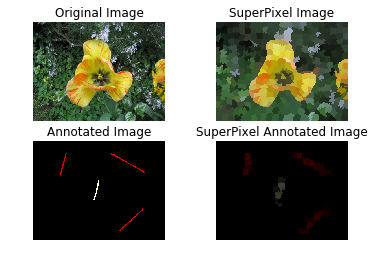

In [4]:
# convert image into super-pixel
sup_pixel = slic(flower, n_segments=400, compactness=30, sigma=0.5)

# convert super-pixel image into RGB, where RGB is mean RGB of the superpixel in original image
color_sup_pixel = color.label2rgb(sup_pixel,flower, kind='avg')

# convert super-pixel image into RGB, where RGB is mean RGB of the superpixel in original image
# this is useful for checking if super-pixel is background, foreground, or un-annotated
anno_sup_pixel = color.label2rgb(sup_pixel,flower_anno, kind='avg')

# plot all these images
plt.subplot(2,2,1)
plt.imshow(flower)
plt.axis('off')
plt.title('Original Image')
plt.subplot(2,2,2)
plt.imshow(color_sup_pixel)
plt.axis('off')
plt.title('SuperPixel Image')
plt.subplot(2,2,3)
plt.imshow(flower_anno)
plt.axis('off')
plt.title('Annotated Image')
plt.subplot(2,2,4)
plt.imshow(anno_sup_pixel)
plt.axis('off')
plt.title('SuperPixel Annotated Image')
plt.show()

In [5]:
def check_pixel_type(pixel, sup_pixel_anno):
  # Returns pixel type
  # If black than Unknown, if yellow than ForeGround, If red that backGround
  # 0-Unkown, 1-ForeGround, 2-BackGround
  pixel = pixel.astype('int')

  pixel_RGB = sup_pixel_anno[pixel[0],pixel[1],:]
  p_type = 10
  
  if ((pixel_RGB[0]==0.0) and (pixel_RGB[1]==0.0) and (pixel_RGB[2]==0.0)):
    p_type=0
  elif ((pixel_RGB[0]>0.0) and (pixel_RGB[1]>0.0) and (pixel_RGB[2]>0.0)):
    p_type=1
  else:
    p_type=2
    
  return p_type
  

In [6]:
# we will go through each super-pixel.
# Find it's the first pixel, take it as a representation of that super-pixel
# We will also generate the adjancency matrix 

regions = regionprops(sup_pixel+1)
num_segments = len(regions)                   # total number of super-pixels

super_pixel_RGB = np.zeros((num_segments,C))  # store mean RGB value of the super-pixel
sup_pixel_type = np.zeros((num_segments,))    # store type of super-pixel: 0-Unkown, 1-ForeGround, 2-BackGround
all_sup_pixels = []                           # store all indices for each super-pixel (Useful for calculating adjacency matrix)
all_bbox = []                                 # store bounding box for each super-pixel (useful for calculating adjacency matrix)

for i,props in enumerate(regions):
  
  # get all pixels for a particular super-pixel and store them  
  segment_pixels = props.coords # shape:(N,2)
  all_sup_pixels.append(segment_pixels)
  
  all_bbox.append(props.bbox)   # shape:(4,) (min_row, min_col, max_row, max_col)
  
  # get first pixel of super pixel as representative pixel  
  rep_pixel = np.array([segment_pixels[0,0],segment_pixels[0,1]])

  # store mean RGB value of superpixel
  super_pixel_RGB[i,:] = color_sup_pixel[rep_pixel[0],rep_pixel[1],:] 
  
  # get pixel type
  sup_pixel_type[i] = check_pixel_type(rep_pixel, anno_sup_pixel) 
  

In [7]:
Sfg = super_pixel_RGB[sup_pixel_type==1] # get all foreground super-pixel
Sbg = super_pixel_RGB[sup_pixel_type==2] # get all background super-pixel
Sna = super_pixel_RGB[sup_pixel_type==0] # get all un-annotated super-pixel

## 3.1 Likelihood $p(S/F)$

In [8]:
print("Total Foreground super pixel: ", Sfg.shape[0])
print("Total Background super pixel: ", Sbg.shape[0])
print("Total number of super pixel: ", super_pixel_RGB.shape[0])

Total Foreground super pixel:  6
Total Background super pixel:  27
Total number of super pixel:  376


In [9]:
# mean of forground and background
mu_fg = np.mean(Sfg,0)
mu_bg = np.mean(Sbg,0)

In [10]:
print("Mean RGB of Foreground: ", mu_fg)
print("Mean RGB of Background: ", mu_bg)

Mean RGB of Foreground:  [0.55599807 0.51740897 0.10192636]
Mean RGB of Background:  [0.18143654 0.25718389 0.18507277]


In [11]:
# Cov of foreground and Background
cov_fg = np.cov(Sfg.transpose())
cov_bg = np.cov(Sbg.transpose())

In [12]:
print("Cov RGB of Foreground: \n\n", cov_fg)
print("\n\n")
print("Cov RGB of Background: \n\n", cov_bg)

Cov RGB of Foreground: 

 [[ 0.02393584  0.01848785 -0.00453216]
 [ 0.01848785  0.01634148 -0.00192977]
 [-0.00453216 -0.00192977  0.00530221]]



Cov RGB of Background: 

 [[0.00925688 0.01125458 0.01108173]
 [0.01125458 0.01512229 0.01327724]
 [0.01108173 0.01327724 0.0136262 ]]


In [13]:
# Gaussain for foreground and background
GDF_fg = multivariate_normal(mean=mu_fg, cov=cov_fg)
GDF_bg = multivariate_normal(mean=mu_bg, cov=cov_bg)

In [14]:
P_fg = GDF_fg.pdf(super_pixel_RGB) # Likelihood of all pixel belonging to foreground (P(s_i / f_i = foreground))
P_bg = GDF_bg.pdf(super_pixel_RGB) # Likelihood of all pixel belonging to background (P(s_i / f_i = background))

In [15]:
def get_sup_pixel_log_likelihood(super_pixel_seg_image, P_fg, P_bg, index):
  # returns log likelihood of the super pixel belonging to either forground or background
  # log (P(s_i/f_i))
  """
  super_pixel_seg_image: Labelled super_pixels: Shape(N,)
  P_fg: Likelihood of super_pixel belonging forground: Shape(N,)
  P_bg: Likelihood of super_pixel belonging to background: Shape(N,) 
  index: Index of the super-pixel 
  """ 
  
  if(super_pixel_seg_image[index] == 1):
    log_likelihood = np.log(P_fg[index])
  else:
    log_likelihood = np.log(P_bg[index])

  return log_likelihood


In [16]:
def get_configuration_log_likelihood(super_pixel_seg_image, P_fg, P_bg):
  # returns log likelihood of the whole configuration, i.e. super_pixel_seg_image
  # log(P(S/F)) = sum_i log (P(s_i/f_i))

  """
  super_pixel_seg_image: Labelled super_pixels: Shape(N,)
  P_fg: Likelihood of super_pixel belonging forground: Shape(N,)
  P_bg: Likelihood of super_pixel belonging to background: Shape(N,) 
  """ 

  log_likelihood = 0
  
  for i in range(len(super_pixel_seg_image)):
    log_likelihood += get_sup_pixel_log_likelihood(super_pixel_seg_image, P_fg, P_bg, i)

  return log_likelihood


## 3.2 Prior $p(F)$



In [17]:
def check_bbox_overlap(bb1, bb2):
    #(min_row, min_col, max_row, max_col)
    #[min_row; max_row) and [min_col; max_col)
    
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        overlap = 0
    else:
        overlap = 1
        
    return overlap

In [18]:
Adj_Mat = np.zeros((num_segments,num_segments))


for i in range(num_segments):
  
  Adj_Mat[i,i] = 0 # diagonal is always 0 (site is not its neighbour)

  for j in range(i+1,num_segments):
    
    # check if there is bbox overlap between two super-pixel
    if check_bbox_overlap(all_bbox[i], all_bbox[j]):

      # if bbox overlap, than check if they share boundary or not
      # by checking min distance between all pixels of both super-pixel
      if np.min(cdist(all_sup_pixels[i],all_sup_pixels[j])) <= 1:
      
        Adj_Mat[i,j] = 1
        Adj_Mat[j,i] = 1 # adjancency matrix is symmetric
        
    

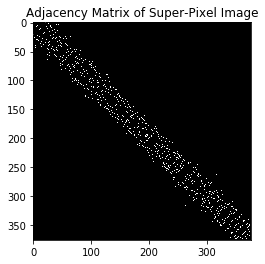

In [19]:
plt.imshow(Adj_Mat, cmap='gray')
plt.title('Adjacency Matrix of Super-Pixel Image')
plt.show()

In [20]:
def get_sup_pixel_log_prior(super_pixel_seg_image, Adj_Mat, beta, index):
  # returns log prior of the super pixel 
  # log P(f_i) = sum_j log(P(f_i,f_j)), where j={N_i} and log(P(f_i,f_j)) = -beta 
  """
  super_pixel_seg_image: Labelled super_pixels: Shape (N,)
  Adj_Mat: Adjacency Matrix: Shape (N,N)  
  beta: value of beta
  index: Index of the super-pixel 
  """ 
  index_value = super_pixel_seg_image[index]

  log_prior = 0

  for j in range(len(super_pixel_seg_image)):
    #  check if neighbours, check if has different labels
    if (Adj_Mat[index,j]==1) and (super_pixel_seg_image[j] != index_value):
      log_prior += -beta 
  
  return log_prior


In [21]:
def get_configuration_log_prior(super_pixel_seg_image, Adj_Mat, beta):
  # returns log prior of the whole configuration , i.e., sup_pixel_seg_image
  # log P(F) = Sum_i log(P(f_i))
  """
  super_pixel_seg_image: Labelled super_pixels: Shape (N,)
  Adj_Mat: Adjacency Matrix: Shape (N,N)  
  beta: value of beta
  """ 

  log_prior = 0

  for i in range(len(super_pixel_seg_image)):
    log_prior += get_sup_pixel_log_prior(super_pixel_seg_image, Adj_Mat, beta, i) 
  
  return log_prior


## 3.3 Posterior

### 3.3.1 Distribution $\pi_0$


In [22]:
def display_super_pixel_image(super_pixel_labels, sup_pixel_image, title_string):
  """
  super_pixel_labels: array of size (N,) where each super_pixel is labeled
  super_pixel_image: super_pixeled_image of size (H,W)
  title_string: Title of for the display
  """
  seg_sup_pixel = np.zeros(sup_pixel_image.shape, dtype = "uint8")

  for segVal in np.unique(sup_pixel_image):  
    if super_pixel_labels[segVal] > 0:  
      seg_sup_pixel[sup_pixel_image == segVal] = 255

  plt.imshow(seg_sup_pixel, cmap='gray')
  plt.title(title_string)
  plt.show()

In [23]:
def convert_super_pixel_to_image(super_pixel_labels, sup_pixel_image):
  """
  super_pixel_labels: array of size (N,) where each super_pixel is labeled
  super_pixel_image: super_pixeled_image of size (H,W)
  title_string: Title of for the display
  """
  seg_sup_pixel = np.zeros(sup_pixel_image.shape, dtype = "uint8")

  for segVal in np.unique(sup_pixel_image):  
    if super_pixel_labels[segVal] > 0:  
      seg_sup_pixel[sup_pixel_image == segVal] = 255

  return seg_sup_pixel

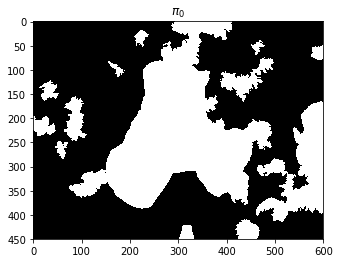

In [24]:
seg_2 = mpimg.imread(data_path+"seg_2.jpg")
#seg_2.flags
seg_2.setflags(write=1)
seg_2[seg_2>0] = 1 #convert into binary

# Initial Distibution pi_0
pi_0 = np.zeros(len(np.unique(sup_pixel)))

for (i, segVal) in enumerate(np.unique(sup_pixel)):  
  # check if mean of all pixel in superpixel is greater than 0.5 
  if seg_2[sup_pixel == segVal].mean()>=0.5:
    pi_0[i] = 1 
    
    
display_super_pixel_image(pi_0, sup_pixel, '$\pi_0$')

### 3.3.2 Distribution $q(F^{(t)}/ F^{(t-1)})$

In [25]:
def get_sup_pixel_f_t(f_t_m_1, t): #, index=0):
  # according to discussion board
  # returns q(f_i^t/f_i^(t-1)) for a super-pixel according to the proposal distribution  

  # Assume forground = 1 and background = 0. When f(i, t-1) = 0, sampling would work as follows. Similar can be coded for f(i, t-1) = 1.
  # q( f(i,t) | f(i,t-1) ) = N( f(i,t) | f(i,t-i), sigma )
  # q( 1 | 0 ) = N( 1 | 0, sigma)
  # q( 0 | 0 ) = N( 0 | 0, sigma)
  # Draw a uniform random number x in range [0,1].
  # if x < q( 1 | 0) / (q( 1 | 0) + q( 0 | 0)): f(i,t) = 1
  # else f(i,t) = 0.

  """
  F_t_m_1: label of the super-pixels at time t-1
  t: value of time t
  index: index of the super-pixel
  """
  
  std = np.sqrt(3/np.log(t+1))

  #q_t = norm(F_t_m_1[index], std)
  q_t = norm(f_t_m_1, std)
  
  q_t_c = q_t.pdf(1-f_t_m_1)
  q_t_s = q_t.pdf(f_t_m_1)
  
  q_ft_ft_1 = q_t_c/(q_t_c + q_t_s) 

  x = np.random.uniform(0,1)
  
  if x < q_ft_ft_1:
    #f_t = 1 - F_t_m_1[index]
    f_t = 1 - f_t_m_1
  else:
    #f_t = F_t_m_1[index]
    f_t = f_t_m_1
    
  return f_t, q_ft_ft_1   

In [26]:
def get_configuration_F_t(F_t_m_1, t):
  # returns F_t for a configuration according to the proposal distribution  
  # q(F_t/F_(t-1)) = Mul_i q(f_i^t/f_i^(t-1))
  """
  F_t_m_1: label of the configuration at time t-1: shape: (N,)
  t: value of time t
  """
  F_t = np.zeros_like(F_t_m_1) 

  q_Ft_Ft_1 = 1

  for i in range(len(F_t_m_1)):
    #F_t[i], temp = get_sup_pixel_f_t(F_t_m_1, t, i)
    F_t[i], temp = get_sup_pixel_f_t(F_t_m_1[i], t)
    q_Ft_Ft_1 *= temp

  return F_t, q_Ft_Ft_1 

### 3.3.3 Visualization

In [27]:
def display_sample_proposal(sample, proposal, sup_pixel_image, itr):
  """
  samples: array of size (N,) where each super_pixel is labeled
  proposal: array of size (N,) 
  super_pixel_image: super_pixeled_image of size (H,W)
  itr: itr number
  """
  sample_sup_pixel = np.zeros(sup_pixel_image.shape, dtype = "uint8")
  proposal_sup_pixel = np.zeros(sup_pixel_image.shape, dtype = "uint8")

  for segVal in np.unique(sup_pixel_image):  
    if sample[segVal] > 0:  
      sample_sup_pixel[sup_pixel_image == segVal] = 255
    if proposal[segVal] > 0:  
      proposal_sup_pixel[sup_pixel_image == segVal] = 255

  plt.subplot(121)
  plt.imshow(sample_sup_pixel, cmap='gray')
  plt.title("sample at t="+ str(itr))
  plt.subplot(122)
  plt.imshow(proposal_sup_pixel, cmap='gray')
  plt.title("proposal at t="+ str(itr))
  plt.show()

### Metropolish Sampling

In [28]:
def metropolis_sampling_configuration(sup_pixel_image, super_pixel_seg_image, P_fg, P_bg, Adj_Mat, beta, iterations, display=True):
  """
  sup_pixel_image: super pixel image, useful for displaying intermediate results: Shape: (H,C)
  super_pixel_seg_image: initial sample: Shape: (N,)
  P_fg: probability of each super-pixel belonging to foreground: Shape: (N,)
  P_bg: probability of each super-pixel belonging to background: Shape: (N,)
  Adj_Mat: adjacency matrix of super-pixels: Shape(N,N)
  Beta: hyperparmeter: (1,)
  iterations: total number of iterations of matropolis sampling
  """

  print("Beta:", beta)

  display_freq = int(iterations / 5)

  sample = super_pixel_seg_image.copy()

  start = time.time() 
  for itr in range(1,iterations+1):
    
    # calculate sample log joint
    sample_log_likelihood = get_configuration_log_likelihood(sample, P_fg, P_bg)
    sample_log_prior = get_configuration_log_prior(sample, Adj_Mat, beta)
    sample_log_joint = sample_log_prior + sample_log_likelihood
    sample_joint = np.exp(sample_log_joint)
    
    # get new proposal configuration
    proposal, q_Ft_Ft_1 = get_configuration_F_t(sample, itr)

    # calculate proposal log joint
    proposal_log_likelihood = get_configuration_log_likelihood(proposal, P_fg, P_bg)
    proposal_log_prior = get_configuration_log_prior(proposal, Adj_Mat, beta)
    proposal_log_joint = proposal_log_prior + proposal_log_likelihood
    proposal_joint = np.exp(proposal_log_joint)
    

    if proposal_joint > sample_joint:
      # accept the proposal
      sample = proposal.copy()
      print("Proposal Accepted at iteration: ", itr)
      print("q_Ft_Ft-1: ", q_Ft_Ft_1)
    else:
      R = np.random.uniform(0,1)
      if R < (proposal_joint/sample_joint):
        # accept the proposal
        sample = proposal.copy()
        print("Proposal Accepted at iteration: ", itr)
        print("q_Ft_Ft-1: ", q_Ft_Ft_1)
      else:
        # reject the proposal
        pass
    
    if (itr%display_freq == 0) and display:
      end = time.time()
      print("Total time for last {} iterations: {} secs".format(itr, end - start))
      #display_super_pixel_image(sample, sup_pixel_image, 'iteration:'+str(itr))
      display_sample_proposal(sample, proposal, sup_pixel_image, itr)
      start = time.time()
      print("proposal_joint:",proposal_joint)
      print("sample_joint:",sample_joint)
      print("joint ratio:",proposal_joint / sample_joint)
      print("proposal_log_joint:",proposal_log_joint)
      print("sample_log_joint:",sample_log_joint)
      print("proposal_log_prior:",proposal_log_prior)
      print("sample_log_prior:",sample_log_prior)
      print("proposal_log_likelihood:",proposal_log_likelihood)
      print("sample_log_likelihood:",sample_log_likelihood)
      print("\n")
      
  return sample  
    

#### Run Metropolis sampling and display $q(f_i^{(t)}/f_i^{t-1})$ and labeling for 5 intermediate iterations


Beta: 1


/home/raghav/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Total time for last 100 iterations: 32.00858545303345 secs


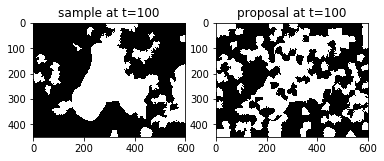

proposal_joint: 0.0
sample_joint: 3.501644282964256e-18
joint ratio: 0.0
proposal_log_joint: -inf
sample_log_joint: -40.19329902058399
proposal_log_prior: -934
sample_log_prior: -452
proposal_log_likelihood: -inf
sample_log_likelihood: 411.806700979416


Total time for last 200 iterations: 35.35894823074341 secs


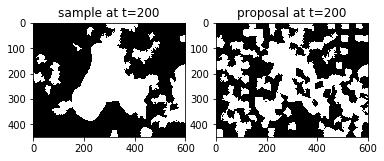

proposal_joint: 0.0
sample_joint: 3.501644282964256e-18
joint ratio: 0.0
proposal_log_joint: -inf
sample_log_joint: -40.19329902058399
proposal_log_prior: -976
sample_log_prior: -452
proposal_log_likelihood: -inf
sample_log_likelihood: 411.806700979416


Total time for last 300 iterations: 32.22627305984497 secs


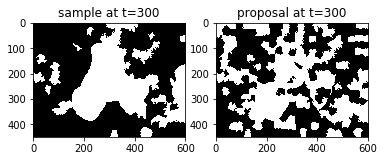

proposal_joint: 0.0
sample_joint: 3.501644282964256e-18
joint ratio: 0.0
proposal_log_joint: -inf
sample_log_joint: -40.19329902058399
proposal_log_prior: -922
sample_log_prior: -452
proposal_log_likelihood: -inf
sample_log_likelihood: 411.806700979416


Total time for last 400 iterations: 32.16492009162903 secs


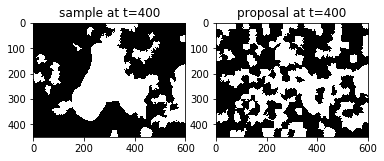

proposal_joint: 0.0
sample_joint: 3.501644282964256e-18
joint ratio: 0.0
proposal_log_joint: -inf
sample_log_joint: -40.19329902058399
proposal_log_prior: -938
sample_log_prior: -452
proposal_log_likelihood: -inf
sample_log_likelihood: 411.806700979416


Total time for last 500 iterations: 31.99225115776062 secs


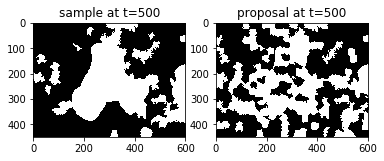

proposal_joint: 0.0
sample_joint: 3.501644282964256e-18
joint ratio: 0.0
proposal_log_joint: -inf
sample_log_joint: -40.19329902058399
proposal_log_prior: -898
sample_log_prior: -452
proposal_log_likelihood: -inf
sample_log_likelihood: 411.806700979416




In [29]:
# Run metropolis sampling for b=1.0 for 500 iterations 
sample = metropolis_sampling_configuration(sup_pixel, pi_0, P_fg, P_bg, Adj_Mat, 1, 500)

#### Sample 10 configurations at the end from the final sample

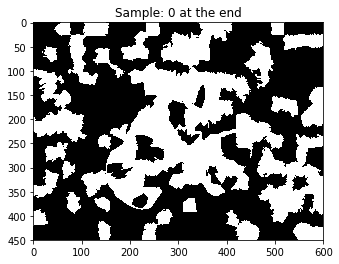

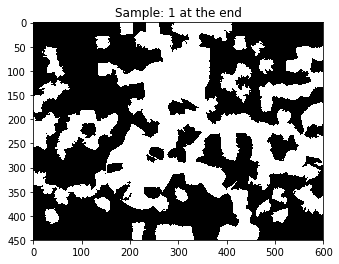

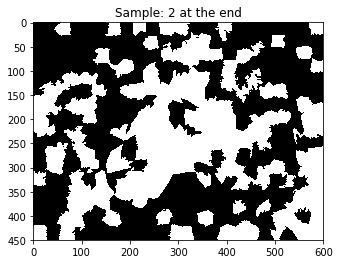

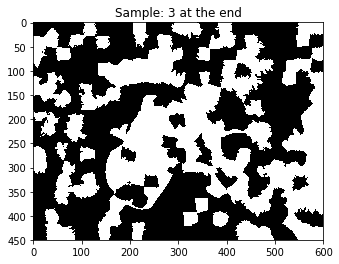

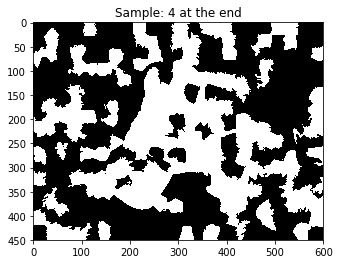

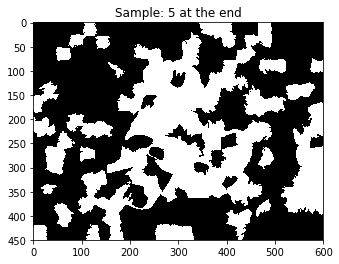

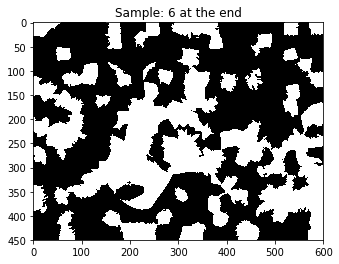

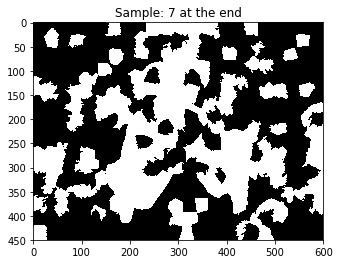

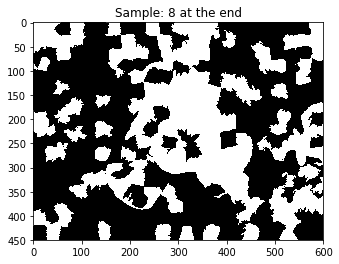

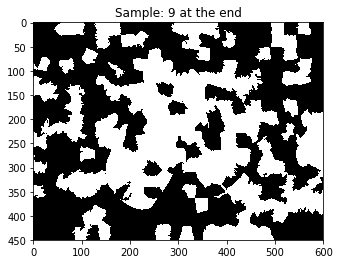

In [30]:
s = np.zeros([10, sup_pixel.shape[0], sup_pixel.shape[1]])

for i in range(10):
  s_sup, _ = get_configuration_F_t(sample, 500)
  s[i,:,:] = convert_super_pixel_to_image(s_sup, sup_pixel)
  plt.imshow(s[i,:,:], cmap="gray")
  plt.title('Sample: '+str(i)+' at the end')
  plt.show()  

#### mode of 10 samples

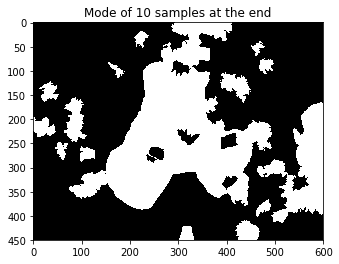

In [31]:
s_mean = np.mean(s,0)
s_mean[s_mean>128] = 255
s_mean[s_mean<=128] = 0
plt.imshow(s_mean, cmap="gray")
plt.title("Mode of 10 samples at the end")
plt.show()

#### Run metropolis sampling for 500 iterations for different values of $\beta$=(0.01, 0.1, 1.0)

Beta: 0.01


/home/raghav/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


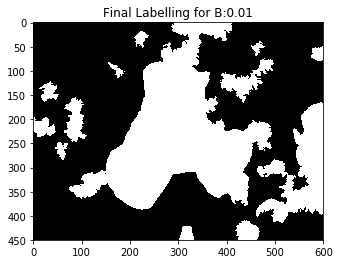

Beta: 0.1


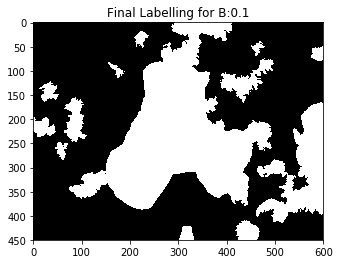

Beta: 1.0


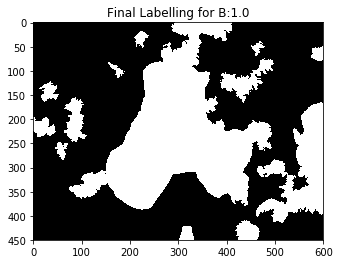

In [32]:
betas = [0.01, 0.1, 1.0]

for beta in betas:
  sample = metropolis_sampling_configuration(sup_pixel, pi_0, P_fg, P_bg, Adj_Mat, beta, 200, display=False)
  display_super_pixel_image(sample, sup_pixel, 'Final Labelling for B:'+str(beta))

### Gibbs Sampling

In [33]:
def gibbs_sampling_sup_pixel(sup_pixel_image, super_pixel_seg_image, P_fg, P_bg, Adj_Mat, beta, iterations, display=True):
  """
  sup_pixel_image: super pixel image, useful for displaying intermediate results: Shape: (H,C)
  super_pixel_seg_image: initial sample: Shape: (N,)
  P_fg: probability of each super-pixel belonging to foreground: Shape: (N,)
  P_bg: probability of each super-pixel belonging to background: Shape: (N,)
  Adj_Mat: adjacency matrix of super-pixels: Shape(N,N)
  Beta: hyperparmeter: (1,)
  iterations: total number of iterations of matropolis sampling
  """

  print("Beta:", beta)

  display_freq = int(iterations / 5)

  sample = super_pixel_seg_image.copy()

  start = time.time() 
  
  # iterate through iterations
  for itr in range(1,iterations+1):
    
    # store proposal distributions for time t 
    proposal_t = np.zeros_like(sample)
    
    # iterate through individual pixels
    for j in range(len(super_pixel_seg_image)):

      proposal = sample.copy()
      
      # calculate sample log joint
      sample_log_likelihood = get_sup_pixel_log_likelihood(sample, P_fg, P_bg, j)
      sample_log_prior = get_sup_pixel_log_prior(sample, Adj_Mat, beta, j)
      sample_log_joint = sample_log_prior + sample_log_likelihood
      sample_joint = np.exp(sample_log_joint)

      # get new proposal configuration
      #proposal[j], q_ft_ft_1 = get_sup_pixel_f_t(sample, itr, j)      
      proposal[j], q_ft_ft_1 = get_sup_pixel_f_t(sample[j], itr)      
      proposal_t[j] = proposal[j].copy()

      # calculate proposal log joint
      proposal_log_likelihood = get_sup_pixel_log_likelihood(proposal, P_fg, P_bg, j)
      proposal_log_prior = get_sup_pixel_log_prior(proposal, Adj_Mat, beta, j)
      proposal_log_joint = proposal_log_prior + proposal_log_likelihood
      proposal_joint = np.exp(proposal_log_joint)


      if proposal_joint > sample_joint:
        # accept the proposal
        sample = proposal.copy()
      else:
        R = np.random.uniform(0,1)
        if R < (proposal_joint/sample_joint):
          # accept the proposal
          sample = proposal.copy()
        else:
          # reject the proposal
          pass

    if (itr%display_freq == 0) and display:
      display_sample_proposal(sample, proposal_t, sup_pixel_image, itr)
      start = time.time()
      
  return sample    

#### Run Gibbs sampling and display $q(f_i^{(t)}/f_i^{t-1})$ and labeling for 5 intermediate iterations

Beta: 0.1


/home/raghav/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


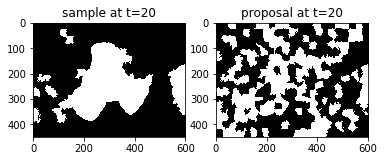

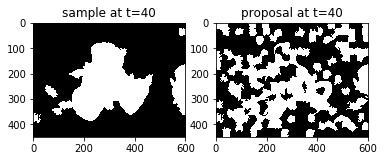

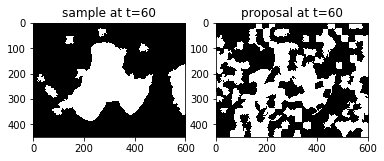

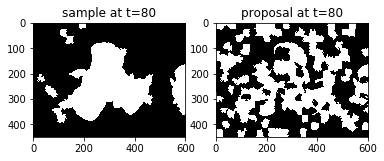

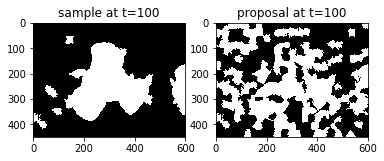

In [35]:
sample = gibbs_sampling_sup_pixel(sup_pixel, pi_0, P_fg, P_bg, Adj_Mat, 0.1, 100)

#### Sample 10 configurations at the end from the final sample

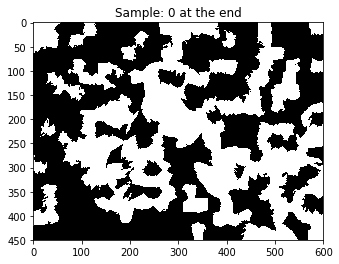

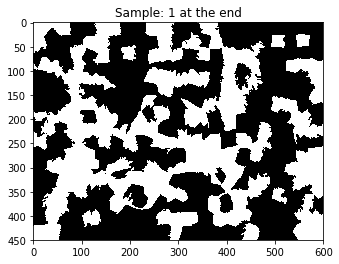

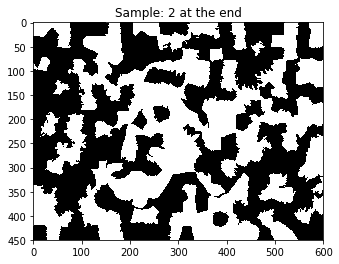

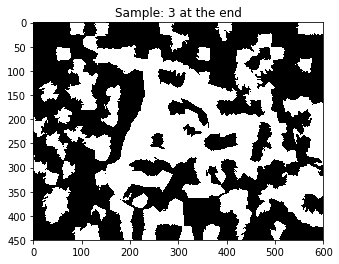

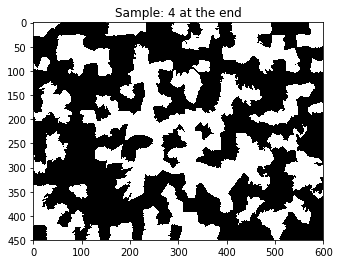

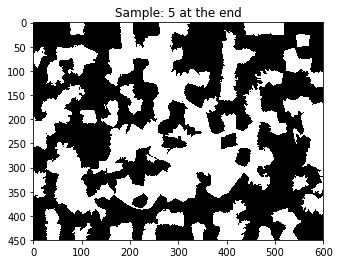

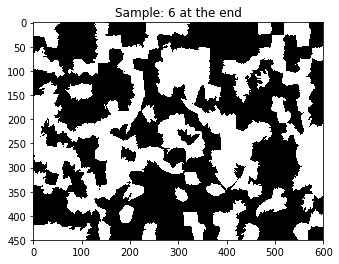

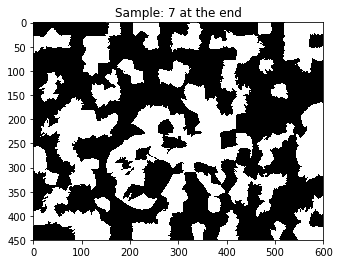

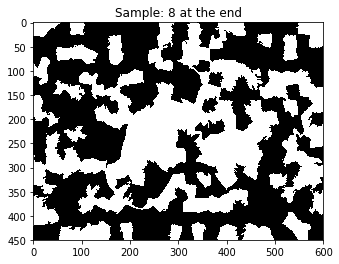

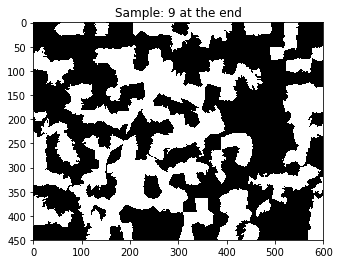

In [36]:
s = np.zeros([10, sup_pixel.shape[0], sup_pixel.shape[1]])

for i in range(10):
  s_sup, _ = get_configuration_F_t(sample, 25)
  s[i,:,:] = convert_super_pixel_to_image(s_sup, sup_pixel)
  plt.imshow(s[i,:,:], cmap="gray")
  plt.title('Sample: '+str(i)+' at the end')
  plt.show()  

#### mode of 10 samples

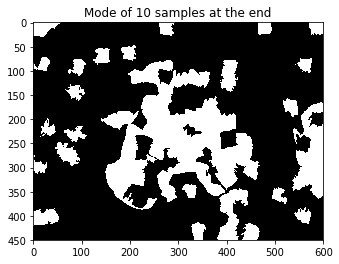

In [37]:
s_mean = np.mean(s,0)
s_mean[s_mean>128] = 255
s_mean[s_mean<=128] = 0
plt.imshow(s_mean, cmap="gray")
plt.title("Mode of 10 samples at the end")
plt.show()

#### Run gibbs sampling for 500 iterations for different values of $\beta$=(0.01, 0.1, 5.0)

Beta: 0.01


/home/raghav/Documents/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


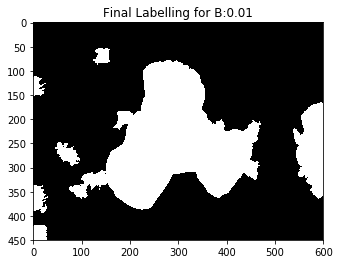

Beta: 0.1


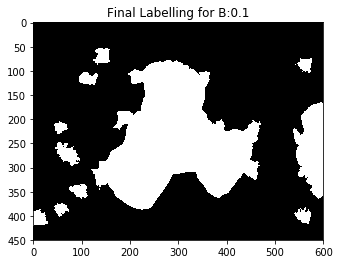

Beta: 5.0


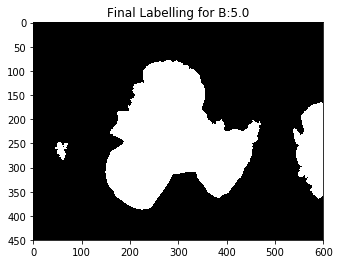

In [38]:
# Run metropolis sampling for 500 iterations for different values of B=(0.01, 0.1, 5.0)
betas = [0.01, 0.1, 5.0]

for beta in betas:
  sample = gibbs_sampling_sup_pixel(sup_pixel, pi_0, P_fg, P_bg, Adj_Mat, beta, 20, display=False)
  display_super_pixel_image(sample, sup_pixel, 'Final Labelling for B:'+str(beta))

We can observe that, with increase in value of $\beta$ smoothing increases.